# Speech Emotion Recognition
# SVM Model

## 01) Importing Libraries

In [31]:
import sys
import os
import argparse
import random
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns

SRC_PATH = "../"
if SRC_PATH not in sys.path:
    sys.path.append(os.path.abspath(SRC_PATH))

from data_utils import load_data_pt, stratified_split, loss_accuracy_graphs, train_epoch, evaluate


## 02) Setting Default Values

In [17]:
DATA_PATH = '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR = '../../models/SVM'

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 6

print(f"DATA_PATH : '{DATA_PATH}'")
print(f"OUT_DIR : '{OUT_DIR}'")
print(f"Device : {DEVICE}")

DATA_PATH : '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR : '../../models/SVM'
Device : cuda


## 03) Method to ensure that Labels are converted as One Dimensional 

In [18]:
def ensure_1d_int_labels(y_tensor):
    """
    Convert torch tensor labels to a 1D numpy int array.
    Accepts shapes like (N,), (N,1), or torch.LongTensor.
    """
    y_np = y_tensor.numpy()
    # collapse to 1D
    y_np = y_np.reshape(-1)
    # convert to int
    if not np.issubdtype(y_np.dtype, np.integer):
        try:
            y_np = y_np.astype(int)
        except Exception:
            raise ValueError("Labels could not be cast to integer dtype.")
    return y_np

## 04) Method to Display The Labels along with no of Data 

In [19]:
def print_label_distribution(y_np, name="dataset"):
    uniq, counts = np.unique(y_np, return_counts=True)
    print(f"Label distribution ({name}): total={len(y_np)}  classes={len(uniq)}")
    for u,c in zip(uniq, counts):
        print(f"  label {u}: {c}")
    return uniq, counts

## 05) Training the Model

In [23]:
random.seed(SEED); np.random.seed(SEED)
X, y, meta = load_data_pt(DATA_PATH)
N, T, D = X.shape
print("Loaded features shape:", X.shape)

try:
    y_np = ensure_1d_int_labels(y)
except Exception as e:
    raise RuntimeError(f"Error converting labels to 1D ints: {e}")

uniq, counts = print_label_distribution(y_np, name="whole dataset")
if len(uniq) < 2:
    raise RuntimeError("Dataset has fewer than 2 unique classes. Cannot train a classifier. "
                       "Check your extractor/balancer outputs.")

X_np = X.numpy().reshape(N, -1)
X_train, X_temp, y_train, y_temp = train_test_split(X_np, y_np, test_size=0.2, stratify=y_np, random_state=SEED)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print("\nAfter stratified split:")
print_label_distribution(y_train, name="train")
print_label_distribution(y_validation, name="val")
print_label_distribution(y_test, name="test")

if len(np.unique(y_train)) < 2:
    raise RuntimeError("Training split contains fewer than 2 classes.")

print("\nTraining SVM (This may take some time)...")
start = time.time()
clf = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=False)
clf.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training finished in {elapsed:.1f} seconds.")

Loaded features shape: torch.Size([3072, 228, 180])
Label distribution (whole dataset): total=3072  classes=8
  label 0: 384
  label 1: 384
  label 2: 384
  label 3: 384
  label 4: 384
  label 5: 384
  label 6: 384
  label 7: 384

After stratified split:
Label distribution (train): total=2457  classes=8
  label 0: 307
  label 1: 308
  label 2: 307
  label 3: 307
  label 4: 307
  label 5: 307
  label 6: 307
  label 7: 307
Label distribution (val): total=307  classes=8
  label 0: 39
  label 1: 38
  label 2: 39
  label 3: 38
  label 4: 38
  label 5: 38
  label 6: 39
  label 7: 38
Label distribution (test): total=308  classes=8
  label 0: 38
  label 1: 38
  label 2: 38
  label 3: 39
  label 4: 39
  label 5: 39
  label 6: 38
  label 7: 39

Training SVM (This may take some time)...
Training finished in 69.6 seconds.


## 06) Saving the Model

In [35]:
os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, "svm.joblib")
joblib.dump(clf, out_path)
print(f"Saved SVM Model to: '{out_path}'")

Saved SVM Model to: '../../models/SVM/svm.joblib'


## 07) Predicting the Values with Test Dataset

In [36]:
preds = clf.predict(X_test)

## 08) Accuracy, Classification Report and Confusion Matrix

--------Test Set Performance--------
Accuracy: 0.8538961038961039
Macro F1 Score: 0.8542097894684788


--------Classification Report--------

               precision    recall  f1-score   support

           0       0.82      0.95      0.88        38
           1       0.77      0.89      0.83        38
           2       0.89      0.87      0.88        38
           3       0.82      0.85      0.84        39
           4       1.00      0.79      0.89        39
           5       0.84      0.82      0.83        39
           6       0.95      0.95      0.95        38
           7       0.78      0.72      0.75        39

    accuracy                           0.85       308
   macro avg       0.86      0.85      0.85       308
weighted avg       0.86      0.85      0.85       308



--------Confusion Maxtrix--------


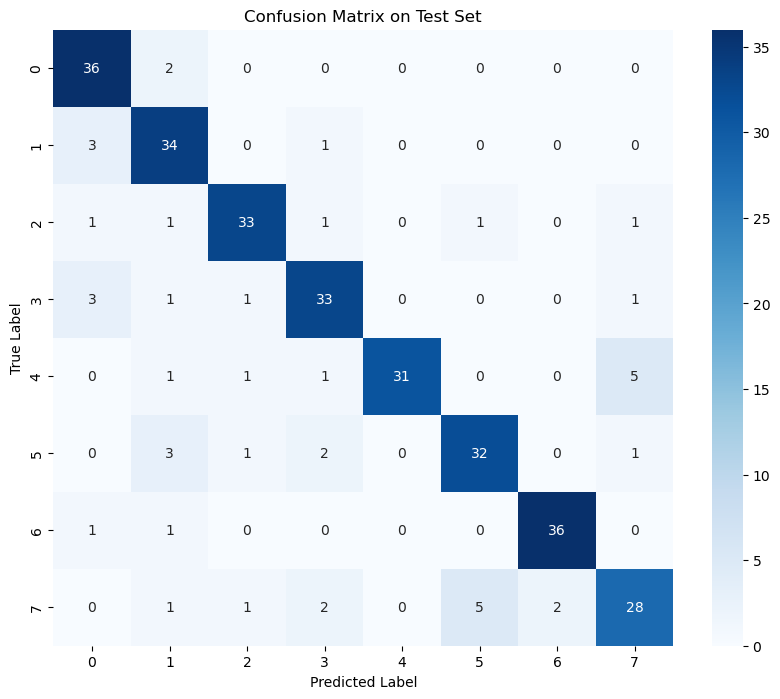

In [37]:
print("--------Test Set Performance--------")
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Macro F1 Score: {f1_score(y_test, preds, average='macro', zero_division=0)}\n\n")
print(f"--------Classification Report--------\n\n {classification_report(y_test, preds)}\n\n")

print("--------Confusion Maxtrix--------")
final_confusion_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(final_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()